# Logistic Regression Assignment
Implement the Logistic Regression learning by gradient ascent as described in class.
Before using logistic regression, be sure to normalize the variables of the training set
to have zero mean and standard deviation 1, and to do the exact same transformation to
the test set, using the mean and standard deviation of the training set

#### Import dependencies

In [37]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score

#### Data loading functions

In [38]:
def get_gisette():
    path = "data/gisette/"   
    
    train_x = np.loadtxt(path+"gisette_train.data")
    train_y = np.loadtxt(path+"gisette_train.labels")
    
    valid_x = np.loadtxt(path+"gisette_valid.data")
    valid_y = np.loadtxt(path+"gisette_valid.labels")
    
    test_x = np.loadtxt(path+"gisette_test.data")

    return train_x, train_y, valid_x, valid_y, test_x



def get_dexter():
    path = "data/dexter/"

    train_x = np.loadtxt(path+"dexter_train.csv", delimiter=',')
    train_y = np.loadtxt(path+"dexter_train.labels")

    valid_x = np.loadtxt(path+"dexter_valid.csv", delimiter=',')
    valid_y = np.loadtxt(path+"dexter_valid.labels")

    return train_x, train_y, valid_x, valid_y

def get_madelon():
    path = "data/MADELON/"

    train_x = np.loadtxt(path + "madelon_train.data")
    train_y = np.loadtxt(path + "madelon_train.labels")
    test_x = np.loadtxt(path + "madelon_valid.data")
    test_y = np.loadtxt(path + "madelon_valid.labels")

    return train_x, train_y, test_x, test_y

#### Normalization function

In [39]:
def normalize(train, *args):
    print(train)
    mean = np.average(train, axis=0)
    standard_deviation = np.std(train, axis=0)
    columns = train, *args
    return tuple(np.divide(column-mean, standard_deviation, where=standard_deviation!=0)
                 for column in columns)



In [40]:
def weights(w, X, eta, y):
    n=w+eta*X.T.dot(y-(1/(1+np.exp(np.dot(-X,w)))))

    return n


In [41]:
def hard_threshold(w, lmbda, eta=0):
    w[w<=lmbda] = 0
    w[w>lmbda] /= 1+eta
    return w

def train_tisp(x_train, y_train, x_test, y_test, threshold):
    iterations = 100
    x_train, x_test = normalize(x_train, x_test)
    x_train = np.hstack((np.ones((x_train.shape[0], 1)), x_train))
    x_test = np.hstack((np.ones((x_test.shape[0], 1)), x_test))
    y_train[y_train==-1] = 0
    y_test[y_test==-1] = 0
    learning_rate = 1 / x_train.shape[0]

    w = np.zeros(x_train.shape[1])
    train_scores = []
    test_scores = []
    train_scores.append(1 - accuracy_score(y_train, predict(x_train, w)))
    test_scores.append(1 - accuracy_score(y_test, predict(x_test, w)))
    for _ in range(iterations):
        w = weights(w, x_train, learning_rate, y_train)
        w = hard_threshold(w, threshold)
        train_scores.append(1 - accuracy_score(y_train, predict(x_train, w)))
        test_scores.append(1 - accuracy_score(y_test, predict(x_test, w)))
    plot(test_scores, train_scores, range(iterations+1))

def predict(X,w):
    return np.round(1 /(1 + np.exp(-X @ w)))

In [42]:
def plot(error_test, error_train, features):
    plt.table(cellText=[[error_train[-1]], [error_test[-1]]], rowLabels=['Training error', 'Test error'], bbox=[0.3,-0.6, .4,.3], edges="closed" )
    plt.plot(features, error_train);
    plt.plot(features, error_test);
    plt.show()

In [43]:
train_x, train_y, test_x, test_y = get_madelon()

[[485. 477. 537. ... 479. 475. 496.]
 [483. 458. 460. ... 492. 510. 517.]
 [487. 542. 499. ... 489. 499. 498.]
 ...
 [480. 517. 631. ... 500. 523. 481.]
 [484. 481. 505. ... 473. 527. 485.]
 [474. 493. 469. ... 489. 516. 516.]]


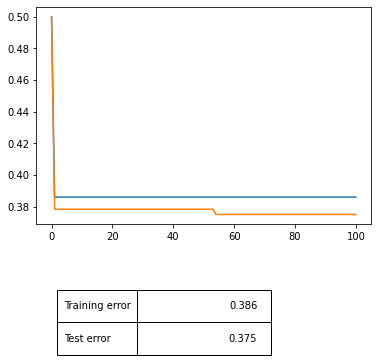

In [44]:
train_tisp(train_x, train_y, test_x, test_y, .05)

In [45]:
train_x, train_y, test_x, test_y = get_dexter()

[[ 0.  0.  0. ...  0.  0. 56.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]]


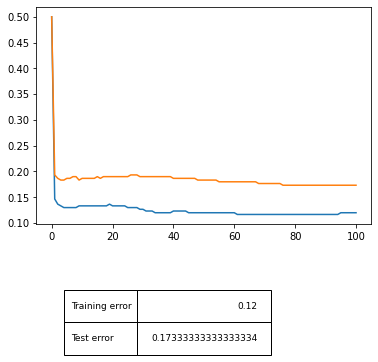

In [46]:
train_tisp(train_x, train_y, test_x, test_y, .1)

In [47]:
train_x, train_y, test_x, test_y, _ = get_gisette()

[[550.   0. 495. ...   0.   0. 983.]
 [  0.   0.   0. ...   0.   0.   0.]
 [  0.   0.   0. ...   0.   0.   0.]
 ...
 [  0.   0.   0. ...   0.   0.   0.]
 [  0.   0.   0. ...   0.   0.   0.]
 [  0.   0. 991. ...   0.   0. 991.]]


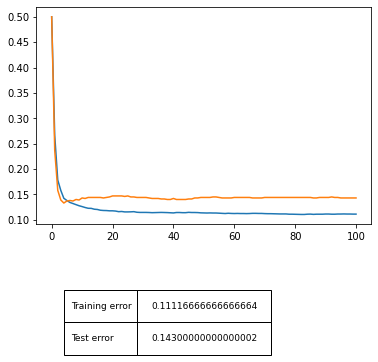

In [48]:
train_tisp(train_x, train_y, test_x, test_y, .01)

In [17]:
train_tisp(train_x, train_y, test_x, test_y, .01)

In [18]:
train_tisp(train_x, train_y, test_x, test_y)


[[485. 477. 537. ... 479. 475. 496.]
 [483. 458. 460. ... 492. 510. 517.]
 [487. 542. 499. ... 489. 499. 498.]
 ...
 [480. 517. 631. ... 500. 523. 481.]
 [484. 481. 505. ... 473. 527. 485.]
 [474. 493. 469. ... 489. 516. 516.]]


ValueError: operands could not be broadcast together with shapes (500,) (500,2000) 